In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from MiningMinima import *
from calc_hessian_at_min import *
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python27.ubuntu 2019.33+release.1e60c63beb532fd475f0f704d68d462b8af2a977 2019-08-09T15:19:57] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r230 2019.33+release.1e60c63beb5 1e60c63beb532fd475f0f704d68d462b8af2a977 http://www.pyrosetta.org 2019-08-09T15:19:57
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2019.33+release.1e60c63beb5-py2.7-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=24610373 seed_offset=0 real_seed=24610373
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=24610373 RG_type=mt19937


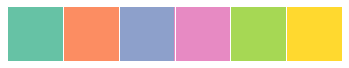

In [3]:
sns.set()
palette = 'Set2'
sns.palplot(sns.color_palette(palette))
sns.set_palette(sns.color_palette(palette))
sns.set_style('whitegrid')
sns.set_context('notebook')

### Some useful parameters for later on

In [4]:
limit = np.pi/3
dx = 0.001
F = np.linspace(-100, 800, 9001)
dF = 0.1

### Developing subroutine to extract function derivative evaluations

In [954]:
# use mm object to get stuff 
seq1, seq2 = 'gga', 'ucc'
mm_sim = MiningMinima(infile='/mnt/c/Users/maadr/all_canonical_reweight/gga_ucc/ST/min.pdb', scorefxn='stepwise/rna/turner_new')

core.import_pose.import_pose: File '/mnt/c/Users/maadr/all_canonical_reweight/gga_ucc/ST/min.pdb' automatically determined to be of type PDB
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.000157609 Finite Diff= 0.000466406


In [955]:
print mm_sim.eigenvalues

[5.05024854e-03 4.62620482e+00 6.60113398e+00 9.46885607e+00
 1.12786111e+01 1.25425835e+01 1.89308132e+01 2.41275004e+01
 3.02013779e+01 4.59838994e+01 5.81964255e+01 7.17116844e+01
 7.62975014e+01 1.25975164e+02 1.46200541e+02 1.79284255e+02
 2.93097335e+02 3.40878114e+02 9.08125289e+02 1.14637273e+03
 1.37633003e+03 1.89624592e+03 5.57138064e+03 9.63094610e+03
 1.60075080e+04 2.59457538e+04]


In [956]:
mm_sim.min_energy - mm_sim.total_log_harmonic

-24.857591562240763

In [957]:
# get pose and scorefxn 
pose = protocols.recces.pose_setup_turner(seq1=seq1, seq2=seq2)
scorefxn = mm_sim.scorefxn

# set up movemap -- for now just get from the MM object -- and min map
movemap = MoveMap()
movemap.assign(mm_sim.movemap)  
min_map = core.optimization.MinimizerMap()
min_map.setup(pose, movemap)
n = min_map.nangles()

# set up min options
min_options = core.optimization.MinimizerOptions(
    'lbfgs_armijo_nonmonotone', 1e-30, True, False, False)
min_options.nblist_auto_update(True)
min_options.max_iter(1000000000)
# get scorefunction ready for minimization
start_score = scorefxn(pose)
pose.energies().set_use_nblist(pose,min_map.domain_map(), True)
multifunc = core.optimization.AtomTreeMultifunc(pose, min_map, scorefxn)
scorefxn.setup_for_minimizing(pose, min_map) # this is the key command
scorefxn.setup_for_derivatives(pose)

min_dofs = Vector1([0.0]*min_map.nangles())
min_map.copy_dofs_from_pose(pose,min_dofs)
start_func_val = multifunc(min_dofs)
theta = Vector1(list(min_dofs))
dE_dtheta = Vector1(list(min_dofs))
multifunc.dfunc(theta,dE_dtheta)

# set up minimizer and run
minimizer = core.optimization.Minimizer(multifunc, min_options)
for _ in range(1): minimizer.run(min_dofs)
print dE_dtheta

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 7.45058e-09 Deriv= -1.95589e-05 Finite Diff= 0.0116234
vector1_double[0.204236, 0.818335, 1.82066, -1.05552, 5.38445, -1.89297, 1.37709, -0.579835, -3.73109, 4.83277, 2.35129, 0.0289665, 2.56135, 0.0817805, 1.30417, -5.63551, 11.4594, -5.25188, 6.94324, -4.80557, -5.98501, 10.7529, 8.76755, 9.14961, 7.52379, 2.10211]


In [958]:
min_options = core.optimization.MinimizerOptions(
    'dfpmin', 1e-30, True, False, False)
min_options.nblist_auto_update(True)
min_options.max_iter(100000000)
dfp_minimizer = core.optimization.Minimizer(multifunc, min_options)

In [959]:
multifunc(min_dofs)

-65.11110761724218

In [960]:
mm_sim.multifunc(Vector1(list(mm_sim.min_dofs)))

-65.17830429916899

# Developing subroutine to calculate hessian from derivative evaluations

In [961]:
def hessian_at_min(min_dofs, multifunc, h=1.5e-5):
    min_dofs = np.array(min_dofs) # take advantage of numpy array indexing
    n_dofs = len(min_dofs)
    hessian = np.zeros((n_dofs,n_dofs))
    plus = Vector1([0.0]*n_dofs)
    plusplus = Vector1(list(plus))
    minus = Vector1(list(plus))
    minusminus = Vector1(list(minus))
    naught = Vector1(list(minus))
    
    
    for ii in range(n_dofs):
        new_dofs = np.array(min_dofs)
        #multifunc.dfunc(Vector1(list(new_dofs)), naught)
        #new_dofs[ii] -= 4*h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)),plusplus)
        new_dofs[ii] += h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), plus)
        new_dofs[ii] -= 2*h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), minus)
        #new_dofs[ii] += h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)), minusminus)
        row = (np.array(plus) - np.array(minus))/h/4.
        hessian[ii] += row
    
    for ii in range(n_dofs):
        new_dofs = np.array(min_dofs)
        #multifunc.dfunc(Vector1(list(new_dofs)), naught)
        #new_dofs[ii] -= 4*h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)),plusplus)
        new_dofs[ii] += h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), plus)
        new_dofs[ii] -= 2*h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)), minus)
        #new_dofs[ii] += h*180./np.pi
        #multifunc.dfunc(Vector1(list(new_dofs)), minusminus)
        row = (np.array(plus) - np.array(minus))/h/4.
        hessian[:,ii] += row
    
    
    return 0.5*(hessian + hessian.T) # enforce symmetry

In [962]:
def hessian_naive(min_dofs, multifunc, h=1e-7):
    
    min_dofs = np.array(min_dofs)
    new_dofs = np.array(list(min_dofs))
    n_dofs = len(min_dofs)
    hessian_at_min = np.zeros((n_dofs, n_dofs))
    
    n_pts = 9
    ind = int(n_pts/2)
    
    tor_ranges = np.zeros((n_pts, n_dofs))
    energy = np.zeros((n_pts,n_pts))
    
    for ii in range(n_dofs):
        tor_ranges[:,ii] = min_dofs[ii] + np.linspace(-ind*h, ind*h, n_pts)*180./np.pi

    for pair in list(itertools.combinations(range(n_dofs), 2)):
        x_torsion = pair[0]
        y_torsion = pair[1]
        x = tor_ranges[:,x_torsion]
        y = tor_ranges[:,y_torsion]

        for ii, xx in enumerate(x):
            new_dofs[x_torsion] = xx

            for jj, yy in enumerate(y):
                new_dofs[y_torsion] = yy
                energy[ii,jj] = multifunc(Vector1(list(new_dofs)))
                new_dofs[y_torsion] = min_dofs[y_torsion]
                
            new_dofs[x_torsion] = min_dofs[x_torsion]
        
        hess = numpy_hessian(energy, h)
        d2E_dx2 =  hess[0,0,:,:]
        d2E_dy2 =  hess[1,1,:,:]
        d2E_dxdy = hess[0,1,:,:]
        
        if hessian_at_min[x_torsion, x_torsion] == 0:
            hessian_at_min[x_torsion, x_torsion] = d2E_dx2[ind,ind]
        if hessian_at_min[y_torsion, y_torsion] == 0:
            hessian_at_min[y_torsion, y_torsion] = d2E_dy2[ind,ind]
        
        hessian_at_min[x_torsion,y_torsion] = d2E_dxdy[ind,ind]
        hessian_at_min[y_torsion,x_torsion] = d2E_dxdy[ind,ind]

    return hessian_at_min

In [963]:
min_dofs = Vector1(list(mm_sim.min_dofs))

for _ in range(10):
    minimizer.run(min_dofs)
    print multifunc(min_dofs)

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 7.45058e-09 Deriv= -2.77978e-06 Finite Diff= 0.0247822
-65.2156749822
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -2.77978e-06 Finite Diff= 0.00341795
-65.2156749822
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -2.77978e-06 Finite Diff= 0.00341795
-65.2156749822
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -2.77978e-06 Finite Diff= 0.00341795
-65.2156749822
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -2.77978e-06 Finite Diff= 0.00341795
-65.2156749822
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -2.77978e-06 Finite Diff= 0.00341795
-65.2156749822
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -2.77978e-06 Finite Diff= 0.00341795
-65.2156749822
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147

In [964]:
def min_func(dofs, multifunc):
    dofs = Vector1(list(dofs))
    dE_dtheta = Vector1(list(dofs))
    energy = multifunc(dofs)
    return energy

def fprime(dofs, multifunc):
    dofs = Vector1(list(dofs))
    dE_dtheta = Vector1(list(dofs))
    multifunc.dfunc(dofs, dE_dtheta)
    dE_dtheta = np.array(dE_dtheta)
    return dE_dtheta*1.0e5

In [965]:
multifunc.dfunc(min_dofs, dE_dtheta)

In [966]:
print dE_dtheta


vector1_double[0.000242221, -0.000236282, -0.000151515, -0.000510603, 0.000108966, 2.80298e-05, 3.34385e-06, -0.000138913, -0.000152818, 0.000132396, 0.000134447, 0.000213369, 0.000810768, 0.000297578, -0.000507955, -0.00022876, 0.000668401, -0.000213569, 0.000351698, -0.00029678, 8.29828e-05, -0.000181183, 0.000107375, 3.80293e-06, -0.000590139, -0.000291974]


In [967]:
from scipy.optimize import minimize

In [968]:
result = minimize(min_func, x0=np.array(min_dofs), args=(multifunc,), jac=fprime, method='L-BFGS-B', tol=1e-16,)

In [969]:
print result.x
print result.message
print result.nfev

[  71.80355791   68.1440972  -147.9346938    31.01445791  -75.38106108
 -157.20776105  -66.90170249  -79.90699635  173.5704956   -61.53608069
   51.59891496   87.47999313 -143.85405244   72.82941505 -149.58369716
   56.66839392  -78.19709175  171.12878539  -67.56938586  -65.72151791
  176.11187108  -73.46631476   54.74840107  101.09819278   83.29066532
   62.49741888]
ABNORMAL_TERMINATION_IN_LNSRCH
21


In [970]:
result = minimize(min_func, x0=np.array(result.x), args=(multifunc,), method='Nelder-Mead', options={'maxfev': 100000}, tol=1.5e-8)

In [971]:
print result.x
print result.message
print result.nfev

[  72.21415683   68.28723029 -148.26404889   31.02695836  -75.21154601
 -157.19411483  -66.73635922  -79.91339745  173.4669016   -61.51251343
   51.60032752   87.79228283 -143.92235515   72.88253351 -149.56304853
   56.50000021  -78.1723324   171.23846753  -67.71593551  -65.61751641
  176.20637255  -73.40607791   54.70014193  101.08188465   83.29199444
   62.53452564]
Optimization terminated successfully.
19359


In [972]:
min_dofs = Vector1(list(result.x))

In [973]:
print multifunc(min_dofs)

-65.2180061854


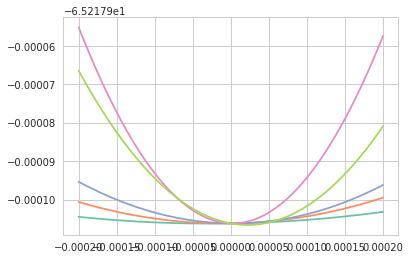

In [974]:
h = np.linspace(-2e-4,2e-4,101)
dh = h[1]-h[0]
out = np.zeros_like(h)
for jj in range(0,5):
    for ii, hh in enumerate(h):
        new_dofs = np.array(min_dofs)
        new_dofs[jj] += hh*180./np.pi
        out[ii] =  multifunc(Vector1(list(new_dofs)))
    plt.plot(h, out)

In [975]:
min_map.copy_dofs_to_pose(pose, Vector1(list(min_dofs)))

In [976]:
hessian = hessian_at_min(min_dofs, multifunc)
#hessian2 = hessian_naive(min_dofs, multifunc)
#hessian2 = 0.5*(hessian2 + hessian2.T) # enforce symmetry 
for ii, do in enumerate(min_map.dof_nodes()):
    hessian[ii] *= min_map.torsion_scale_factor(do)

In [977]:
print hessian
print hessian2

[[ 1.17244971e+02  1.57175615e+02  1.41908377e+02 -2.84259613e+02
   1.32788659e+02 -3.16594971e+02  1.73527361e+02 -2.11319083e+02
   3.00741444e+01 -1.08710121e+02  2.37023674e+02  5.09990960e+00
  -2.69369511e+02  1.40325354e+00  4.43051658e+01 -4.52309605e+02
   2.88270600e+02 -4.25372996e+02  2.60733398e+02 -4.53502787e+02
  -1.20041199e+02 -3.42309641e+01  3.54826643e+02 -1.70692135e+02
   2.97816971e+02 -1.58420679e+02]
 [ 1.57175615e+02  3.06743637e+02  2.23569289e+02 -5.73285632e+02
   2.98785385e+02 -5.83420383e+02  2.20446672e+02 -4.27050767e+02
  -8.27158300e+01 -2.87316174e+02  3.23637144e+02  1.85252371e+01
  -5.26458339e+02  1.78110505e+01  9.20241101e+01 -8.14041210e+02
   5.72327380e+02 -7.51698273e+02  4.63265723e+02 -8.21992926e+02
  -2.63488619e+02 -1.14697448e+02  6.40072252e+02 -3.44679826e+02
   5.71043324e+02 -2.94930875e+02]
 [ 1.41908377e+02  2.23569289e+02  5.19858546e+02 -3.87903480e+02
   7.97954108e+02 -5.97136096e+02  5.87481581e+02 -3.63627423e+02
  -1.3

NameError: name 'hessian2' is not defined

In [978]:
from scipy.linalg import eigh

In [979]:
hessian_pert = hessian + np.random.rand(min_map.nangles(), min_map.nangles())
eigenvalues, modes = scipy.linalg.eigh(hessian)
#eig2, mode2 = eigh(0.5*(hessian2+hessian2.T))

In [980]:
print eigenvalues
#print eig2

[1.31985044e+00 1.77182490e+00 3.32894340e+00 3.84823370e+00
 5.52043579e+00 1.55131289e+01 2.03718643e+01 3.60490169e+01
 3.90762617e+01 4.63688236e+01 8.89807716e+01 1.07473645e+02
 1.59203192e+02 2.03160909e+02 2.75901701e+02 4.79483743e+02
 5.46916643e+02 7.68096644e+02 1.09457359e+03 1.35546537e+03
 1.49542373e+03 2.25179970e+03 5.29997842e+03 9.93218641e+03
 1.62691264e+04 2.70832659e+04]


In [981]:
print eigenvalues
print eig2

[1.31985044e+00 1.77182490e+00 3.32894340e+00 3.84823370e+00
 5.52043579e+00 1.55131289e+01 2.03718643e+01 3.60490169e+01
 3.90762617e+01 4.63688236e+01 8.89807716e+01 1.07473645e+02
 1.59203192e+02 2.03160909e+02 2.75901701e+02 4.79483743e+02
 5.46916643e+02 7.68096644e+02 1.09457359e+03 1.35546537e+03
 1.49542373e+03 2.25179970e+03 5.29997842e+03 9.93218641e+03
 1.62691264e+04 2.70832659e+04]


NameError: name 'eig2' is not defined

In [982]:
fuck, shit, hell = scipy.linalg.svd(hessian)

In [983]:
0.5*np.log(np.product(shit))


66.58214508041789

In [984]:
pseudo_det = 1.
n = 0
for ii, eigen in enumerate(eigenvalues):
    if eigen > 0:
        pseudo_det *= eigen
        n += 1 

In [985]:
print multifunc(min_dofs) + 0.5*np.log(np.product(pseudo_det)) - 0.5*np.log(2*np.pi)*n

-22.528262968286363


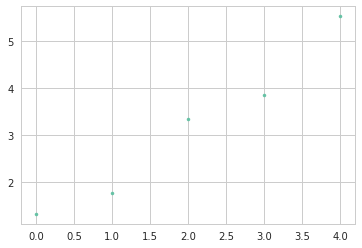

In [986]:
plt.plot(range(len(eigenvalues[:5])), eigenvalues[:5],'.')
#plt.xlabel('index')
#plt.ylabel('eigenvalue')
#plt.legend(('new', 'old'))

# Developing subroutine to mode scan using AtomTreeMultifunc

In [987]:
pmm = PyMOLMover()
pmm.keep_history(True)

In [988]:
from scipy.special import erf

In [989]:
def mode_scan(min_dofs, multifunc, mode, limit=np.pi/3, dx=0.005):
    # convert to np array for useful indexing
    min_dofs = np.array(min_dofs)
    delta_array = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    # initialize result
    result = np.zeros_like(delta_array)
    
    # evaluate using multifunc 
    for ii, delta in enumerate(delta_array):
        result[ii] = pert_eval(delta, min_dofs, mode, multifunc)
    
    return result    
    
def pert_eval(pert, min_dofs, mode, multifunc):
    new_dofs = min_dofs[:] + mode*pert*180./np.pi
    return multifunc(array_to_vector1(new_dofs))

In [990]:
def compute_total_partition(min_dofs, multifunc, modes, limit=np.pi, dx=0.005):
    # initialize output
    total_log_partition = 0 
    total_log_harmonic = 0
    scans = tuple()
    xx = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    for ii, mode in enumerate(modes.T): # columns of array are eigenvectors
        if eigenvalues[ii] < 0: continue
        result = mode_scan(min_dofs, multifunc, mode, limit=limit, dx=dx)
        result -= multifunc(min_dofs)
        scans = scans + (result,)
        total_log_partition += np.log(np.trapz(np.exp(-result),dx=dx))
        #total_log_harmonic += np.log(np.trapz(np.exp(-eigenvalues[ii]*xx**2),dx=dx))
        total_log_harmonic += np.log( np.sqrt(2*np.pi/eigenvalues[ii])*(erf(2*np.pi/np.sqrt(2/eigenvalues[ii]))))
    
    return total_log_partition, total_log_harmonic, np.row_stack(scans)

In [991]:
limit = np.pi/3
dx = 0.005
total_log_partition, total_log_harmonic, mode_scans = compute_total_partition(min_dofs, multifunc, modes, limit=limit, dx=dx)

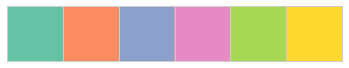

In [992]:
palette = 'Set2'
sns.palplot(sns.color_palette(palette))
sns.set_palette(sns.color_palette(palette))
sns.set_style('whitegrid')
sns.set_context('notebook')

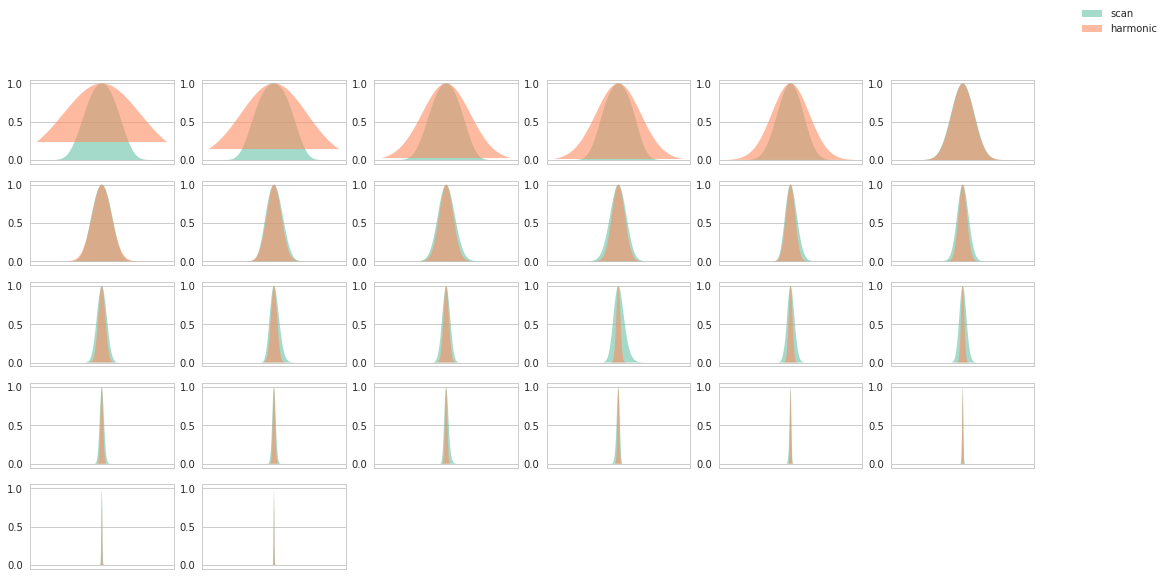

In [993]:
xx = np.linspace(-limit,limit,int(2*limit/dx)+1)
fig, ax = plt.subplots(ncols=6,nrows=5,figsize=(18,9))
for ii, scan in enumerate(mode_scans):
    curr_ax = ax.flatten()[ii]
    curr_ax.fill(xx,np.exp(-scan), alpha=0.6)
    curr_ax.fill(xx,np.exp(-eigenvalues[ii]*xx**2), alpha=0.6)

# turn off unused subplots
for jj in range(ii+1,30):
    curr_ax = ax.flatten()[jj]
    curr_ax.axis('off')
    
for axis in ax.flatten():
    axis.set_xticks([])
    

fig.legend(('scan', 'harmonic'))

In [994]:
from numpy.linalg import det
from numpy import heaviside
from scipy.special import logsumexp, gamma

In [997]:
multifunc(min_dofs) - total_log_harmonic, multifunc(min_dofs) - total_log_partition 

(-22.528262968285844, -18.579354509148743)

In [998]:
pmm = PyMOLMover()
pmm.keep_history(True)
pmm.apply(pose)
h = np.arange(-30,31)
h = np.append(h,h[-2:0:-1])

new_dofs = np.array(min_dofs)
for hh in h:
    new_dofs = min_dofs + hh*modes[0]
    min_map.copy_dofs_to_pose(pose, array_to_vector1(new_dofs))
    pmm.apply(pose)

In [999]:
min_map.copy_dofs_to_pose(pose, array_to_vector1(min_dofs))

In [1000]:
min_E = multifunc(min_dofs)
dos = lambda E: (2.0*np.pi)**(n/2.)*(E-min_E)**(n/2. - 1)/gamma(n/2.)/np.sqrt(pseudo_det)*heaviside(E-min_E,0.5)

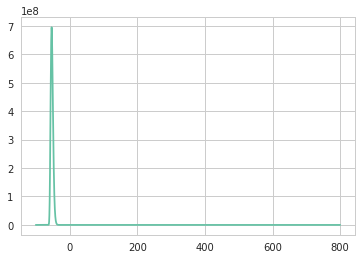

In [1001]:
plt.plot(E, dos(E)*np.exp(-E))

In [1002]:
E = np.linspace(-100, 800, 90001)
dE = E[1]-E[0]
F = np.linspace(-100,800,9001) 
dF = F[1]-F[0]
print -logsumexp(-E, b=dos(E)*dE)

-22.52826296828688


In [1003]:
h = np.linspace(-limit, limit, int(2*limit/0.005) + 1)

In [1004]:
print h**2*eigenvalues[0]

[1.44737797e+00 1.43356060e+00 1.41980950e+00 1.40612467e+00
 1.39250610e+00 1.37895381e+00 1.36546779e+00 1.35204805e+00
 1.33869457e+00 1.32540736e+00 1.31218642e+00 1.29903175e+00
 1.28594335e+00 1.27292123e+00 1.25996537e+00 1.24707578e+00
 1.23425247e+00 1.22149542e+00 1.20880465e+00 1.19618014e+00
 1.18362191e+00 1.17112994e+00 1.15870425e+00 1.14634482e+00
 1.13405167e+00 1.12182479e+00 1.10966417e+00 1.09756983e+00
 1.08554176e+00 1.07357996e+00 1.06168443e+00 1.04985517e+00
 1.03809218e+00 1.02639546e+00 1.01476501e+00 1.00320083e+00
 9.91702920e-01 9.80271282e-01 9.68905914e-01 9.57606816e-01
 9.46373988e-01 9.35207431e-01 9.24107145e-01 9.13073129e-01
 9.02105383e-01 8.91203907e-01 8.80368702e-01 8.69599767e-01
 8.58897103e-01 8.48260709e-01 8.37690585e-01 8.27186732e-01
 8.16749149e-01 8.06377836e-01 7.96072794e-01 7.85834022e-01
 7.75661521e-01 7.65555290e-01 7.55515329e-01 7.45541639e-01
 7.35634219e-01 7.25793069e-01 7.16018190e-01 7.06309581e-01
 6.96667242e-01 6.870911

In [1005]:
len(mode_scans[0])

419

In [1006]:
def calculate_anharmonicitiy(mm_sim):
    w = list([])
    h = np.linspace(-limit, limit, int(2*limit/dx)+1)
    dh = h[1]-h[0]
    
    mode_scans = mm_sim.mode_scans
    eigenvalues = mm_sim.eigenvalues
    for ii in range(mm_sim.n_dofs):
        w_anharmonic = np.trapz(h**2*np.exp(-mode_scans[ii]), dx=h[1]-h[0])/np.trapz(np.exp(-mode_scans[ii]), dx=dh)
        w_harmonic = np.trapz(np.exp(-0.5*eigenvalues[ii]*h**2)*h**2,dx=h[1]-h[0])/np.trapz(np.exp(-0.5*eigenvalues[ii]*h**2), dx=h[1]-h[0])
        w.append(w_anharmonic/w_harmonic)

    return w

In [945]:
calculate_anharmonicitiy(fuck)

AttributeError: 'numpy.ndarray' object has no attribute 'mode_scans'

In [1007]:
limit

1.0471975511965976

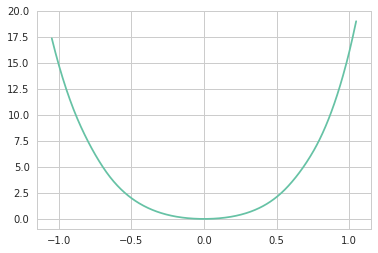

In [1011]:
plt.plot(h,mode_scans[0])

In [1012]:
mm_sim.mode_scans[0]

array([ 1.98066653e+01,  1.96753796e+01,  1.95432578e+01,  1.94103481e+01,
        1.92767187e+01,  1.91424304e+01,  1.90074626e+01,  1.88717748e+01,
        1.87353554e+01,  1.85981783e+01,  1.84602674e+01,  1.83216477e+01,
        1.81823747e+01,  1.80425675e+01,  1.79023248e+01,  1.77616986e+01,
        1.76206939e+01,  1.74793310e+01,  1.73376324e+01,  1.71956164e+01,
        1.70532835e+01,  1.69106102e+01,  1.67676330e+01,  1.66244346e+01,
        1.64810265e+01,  1.63374915e+01,  1.61938909e+01,  1.60503689e+01,
        1.59069847e+01,  1.57637117e+01,  1.56205533e+01,  1.54775231e+01,
        1.53346159e+01,  1.51918694e+01,  1.50492634e+01,  1.49067521e+01,
        1.47643224e+01,  1.46219297e+01,  1.44795758e+01,  1.43372984e+01,
        1.41951095e+01,  1.40529297e+01,  1.39107932e+01,  1.37687691e+01,
        1.36242630e+01,  1.34680143e+01,  1.32998108e+01,  1.31203408e+01,
        1.29303328e+01,  1.27303746e+01,  1.25210679e+01,  1.23030593e+01,
        1.20775880e+01,  

In [1013]:
w = calculate_anharmonicitiy(mm_sim)

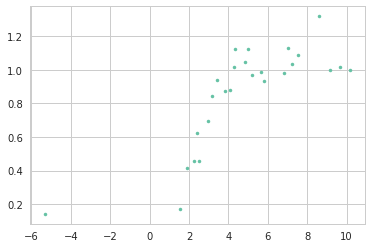

In [1014]:
plt.plot(np.log(mm_sim.eigenvalues), w, '.')

In [1015]:
from recces.data import *
from recces.util import *

In [1016]:
-np.log(np.trapz(dos(F)*np.exp(-F), dx=dF)) + np.log(dF)

-24.830848061280417

In [1017]:
#plt.plot(E, (2*np.pi/3)**(mm_sim.n_dofs)*dos(E)*np.exp(-E)*0.01)
#plt.plot(F, dos(F)*np.exp(-F))
sim = SingleHistSimulation('/mnt/c/Users/maadr/all_canonical_reweight/'+'_'.join((seq1, seq2)))
                      # [0.1,0.118,0.01,0.299,3.61,3.03,0.639,0.033,3.15,2.97])
#plt.plot(sim._dos_scores, sim._dos*np.exp(-sim._dos)*np.exp(-sim._dos_scores))

Inferring sequence from directory name:  gga_ucc
applying phase space volume for two strand with helix length  3  and dangle length  0


In [1018]:
pmm = PyMOLMover()
pmm.keep_history(True)

In [1020]:
sim.value

-28.07509722476422

In [ ]:
def estimate_dos(min_dofs, modes, eigenvalues, multifunc, n=100000):
    # intial parameters
    E = np.linspace(-100,800,9001)
    dE = E[1]-E[0]
    g = np.zeros_like(E)
    
    min_dofs = np.array(min_dofs)
    
    for ii in range(n):
        mode_idx = np.random.randint(5)
        new_dofs = min_dofs + np.random.uniform(-60,60)*modes[mode_idx]
        energy = multifunc(array_to_vector1(new_dofs))
        min_map.copy_dofs_to_pose(pose, array_to_vector1(new_dofs))
        if energy > 800:
            g[-1] += 1
        else: 
            bin_idx = int((energy+100)/dE)
            g[bin_idx] += 1
            
        if ii % 1000 == 0:
            pmm.apply(pose)
    
    return g/n

In [ ]:
dos = estimate_dos(min_dofs, modes, eigenvalues, multifunc)

In [ ]:
hist = SingleHistSimulation('/mnt/c/Users/maadr/all_canonical_reweight/'+seq1+'_'+seq2+'/ST')

In [ ]:
sim.value

In [ ]:
print E, dos
plt.plot(E[:2000], dos[:2000])
plt.plot(E[:2000], hist._dos[:2000]/10000000)
-logsumexp(-E,b=dos)

In [ ]:
limit = np.pi/3
dx = 0.005


sims = ['gaa_uuc', 'gac_guc', 'gag_cuc', 'gau_auc', 'ga_uc', 'gcc_ggc', 'gcg_cgc', 'gga_ucc', 'gg_cc', 'ggc_gcc', 'ggg_ccc', 'ggu_acc', 'gu_ac', 'guc_gac', 'guu_aac']
F = np.linspace(-100,800,9001)
dF = 0.1
anharmonic_E = []
#harmonic_E = []
RECCES_E = []
DOS_E = []
w_dict = {}
sim_dict = {}

E = np.linspace(-100,800,9001)

for sim in sims:
    
    seqs = sim.split('_')
    seq1 = seqs[0]
    seq2 = seqs[1]
    
    fuck = MiningMinima(seq1, seq2, scorefxn='stepwise/rna/turner_new')
    sim_dict[sim] = fuck
    hist = SingleHistSimulation('/mnt/c/Users/maadr/all_canonical_reweight/'+sim+'/ST/')
    
    anharmonic_E.append(fuck.min_energy- fuck.total_log_partition  + np.log(dF))
    RECCES_E.append(hist.value)
    DOS_E.append(-logsumexp(-F,b=fuck.dos(F)*dF) + np.log(dF)) 
    print fuck.eigenvalues
    print sim, anharmonic_E[-1], DOS_E[-1], RECCES_E[-1]
    w_dict[sim] = calculate_anharmonicitiy(fuck)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12,12))
for ii, sim in enumerate(sims):
    n_mods = len(w_dict[sim])
    
    curr_ax = ax.flatten()[ii]
    curr_ax.plot([0, np.log10(np.max(sim_dict[sim].eigenvalues))], [1, 1], 'k--')
    curr_ax.scatter(np.log10(sim_dict[sim].eigenvalues), w_dict[sim])
    curr_ax.set(title=sim)    
    curr_ax.set(xlim=(0, np.log10(np.max(sim_dict[sim].eigenvalues))), ylim=(0,1.6))
    
fig.text(0.5, 0.08, 'log10(eigenvalue)', ha='center', va='center',
         fontproperties=mpl.font_manager.FontProperties(size=14))
fig.text(0.06, 0.5, 'anharmonicity', ha='center', va='center', rotation='vertical', 
         fontproperties=mpl.font_manager.FontProperties(size=14))

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12,12))
for ii, sim in enumerate(sims):
    eigenvalues = sim_dict[sim].eigenvalues
    harmonic_energies = -np.log( np.sqrt(2*np.pi/eigenvalues)*(erf(2*limit/np.sqrt(2/sim_dict[sim].eigenvalues))))
    anharmonic_energies = -np.log(np.trapz(np.exp(-sim_dict[sim].mode_scans), dx=dx))
    curr_ax = ax.flatten()[ii]
    curr_ax.scatter(np.log(eigenvalues), np.abs(harmonic_energies-anharmonic_energies))
    curr_ax.plot([0, np.max(np.log(eigenvalues))], [0, 0], 'k--')
    curr_ax.set(title=sim, xlim=(0, np.log(max(eigenvalues))), ylim=(-0.1,0.5) )   
fig.text(0.5, 0.001, 'log10(eigenvalue)', ha='center', va='center',
         fontproperties=mpl.font_manager.FontProperties(size=14))
fig.text(0.001, 0.5, '$\Delta$E (kT)', ha='center', va='center', rotation='vertical', 
         fontproperties=mpl.font_manager.FontProperties(size=14))
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
norm = plt.Normalize(0,5)

harm = np.array(DOS_E)*KT_IN_KCAL
recces = np.array(RECCES_E)*KT_IN_KCAL
anharm = np.array(anharmonic_E)*KT_IN_KCAL

sc = ax[0].scatter(recces, anharm, c=np.abs(recces-anharm), norm=norm)
ax[1].scatter(recces, harm, c=np.abs(recces-harm), norm=norm)
for axis in ax:
    axis.set(xlim=(-30, -5), ylim=(-30, -5))
    axis.plot([-30,-5],[-30,-5], 'k--')

cbaxes = fig.add_axes([0.94, 0.1, 0.03, 0.8]) 
fig.colorbar(sc, cax=cbaxes)
fig.text(0.5, 0.04, 'RECCES free energy (kcal/mol)', ha='center', va='center')
fig.text(0.06, 0.5, 'estimated free energy (kcal/mol)', ha='center', va='center', rotation='vertical')
print np.sqrt(np.mean((recces-anharm)**2))
print np.sqrt(np.mean((recces-harm)**2))



In [ ]:
from recces.util import *
from recces.data import *

In [ ]:
sim = SingleHistSimulation('./../../../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')

In [ ]:
print sim.value
-np.log(np.trapz(sim._dos, dx=0.1))
'guu_acc'.split('_')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

E = np.linspace(-100,100,2001)

plt.plot(E, fuck.dos(E)*np.exp(-E))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))
plt.xlabel('energy (REU)')
plt.ylabel('$g(E)e^{-E/kT}$')
plt.legend(('MM', 'RECCES'))
print -scipy.special.logsumexp(-E, b=fuck.dos(E)), sim.value, fuck.harmonic_free_energy

In [ ]:
print fuck.anharmonic_free_energy
print fuck.harmonic_free_energy

In [ ]:

print fuck.modes[:,0]
pmm.apply(fuck.min_pose)

In [ ]:
n_struct = 200

ensemble = fuck.harmonic_ensemble(n_struct = n_struct)
#print ensemble[2,:]-min_dofs
#print np.sqrt(H)/np.sqrt((2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((min_dofs-ensemble[0,:])*np.pi/180)**2)/2)

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

hist_min = -100
hist_max = 100
delE = 0.1

hist_scores = np.linspace(hist_min, hist_max, int((hist_max-hist_min)/delE)+1)

hist = np.zeros_like(hist_scores)

for i in range(n_struct):
    
    dofs = ensemble[i,:]
    
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key])
        
    energy = fuck.scorefxn(pose)
    
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1


In [ ]:
shit = hist*np.exp(hist_scores)/np.sum(hist)
shit = shit/np.sum(shit)
print -scipy.special.logsumexp(-hist_scores, b = shit)
plt.plot(hist_scores, shit*np.exp(-hist_scores)/torsion_volume(seq1, seq2))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))

In [ ]:
pose = Pose()
pose_new = Pose()
pose.assign(fuck.min_pose)
for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key],ensemble[0,:][key])

pose_new.assign(pose)

E_0 = fuck.scorefxn(fuck.min_pose)
energy = E_0

min_dofs = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]
curr_dofs = min_dofs
print min_dofs

Z = 0
H = np.product(fuck.eigenvalues)

for j in range(1,n_struct):
    
    trial_move = ensemble[j, :]
     
    for key in fuck.dof_dict: pose_new.set_torsion(fuck.dof_dict[key], trial_move[key]) 

    energy_new = fuck.scorefxn(pose_new)
    
    if np.exp(-(energy_new-energy)) > np.random.random():
        
        energy = energy_new
        pose.assign(pose_new)
        curr_dofs = trial_move
        
    

        #p = np.sqrt(H/(2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((trial_move-min_dofs)*(np.pi/180)**2)**2)/2)
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1

    

In [ ]:
#plt.plot(hist_scores, hist)
shit = hist/np.sum(hist)
shit = shit*np.exp(hist_scores)
shit = shit/np.sum(shit)
#plt.plot(hist_scores, shit)
plt.plot(hist_scores, hist/np.sum(hist))
print -np.log(np.exp(-E_0)*(0.25)**fuck.n_dofs/0.35)


In [ ]:
print ensemble
pmm = PyMOLMover()
pmm.keep_history(True)
print ensemble[1,:]

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

for i in range(200):
    
    dofs = ensemble[i,:]
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key]) 
    pmm.apply(pose)
    

In [ ]:
print np.cov(ensemble)

In [ ]:
w,v = np.linalg.eigh(np.cov(ensemble.T))
print fuck.eigenvalues

In [ ]:
print 1/w*180*180/np.pi/np.pi

In [ ]:

print fuck.min_energy - 0.5*fuck.n_dofs*np.log(2*np.pi) + 0.5*np.log(np.prod(1/w))

In [ ]:
print fuck.anharmonic_free_energy

In [ ]:
print fuck.min_pose

In [ ]:
mu = np.zeros(fuck.n_dofs)

In [ ]:
print mu

In [ ]:
mu = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]

In [ ]:
print mu
bitch = np.linalg.inv(fuck.hessian)

In [ ]:
shit = np.random.multivariate_normal(mu, bitch, size=(2000))

In [ ]:
print shit[0,:]

In [ ]:
random_struct = np.zeros((fuck.n_dofs, 2000))

for j in range(2000):
    
    random_struct[:,j] = np.random.multivariate_normal(mu, bitch)

In [ ]:
print random_struct

In [ ]:
print np.cov(random_struct)

In [ ]:
w,v = np.linalg.eigh(np.cov(random_struct))

In [ ]:
print 1/w


In [ ]:
cu_ag = MiningMinima('cuc', 'gag')

In [ ]:
cu_ag.harmonic_free_energy

In [ ]:
ensemble = cu_ag.harmonic_ensemble()

In [ ]:
cu_ag.eigenvalues

In [ ]:
np.diag(1/cu_ag.eigenvalues)

In [ ]:
np.matmul( np.matmul( cu_ag.modes, np.diag(1/cu_ag.eigenvalues)), cu_ag.modes.T)

In [ ]:
np.linalg.inv(cu_ag.hessian)